## Binomial Tree

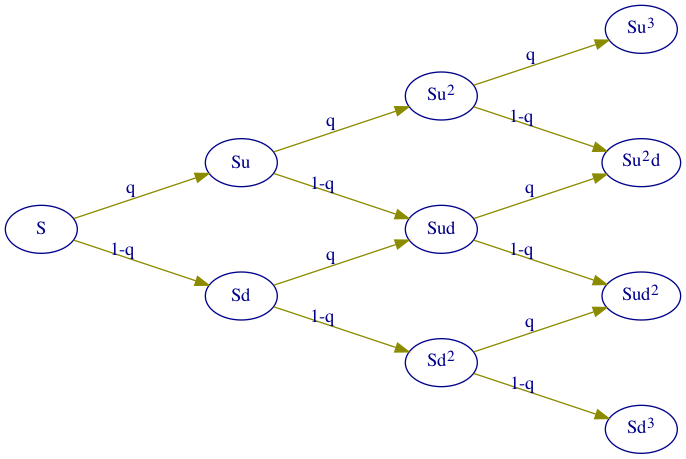

$$log^2(u)=\frac{\sigma^2T}{n}	\Rightarrow u=e^{{\sigma}\sqrt\frac{T}{n}}$$

$$qu+\frac{1-q}{u}=e^{\frac{rT}{n}} \Rightarrow q= \frac{u.e^{\frac{rT}{n}}-1}{u^2-1}=\frac{e^{\frac{rT}{n}}-d}{u-d}$$

### Binomial Tree -
#### Case: Put Option

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm


In [ ]:
def binomial_put(S, K, T, r, vol, N):
    
    # Number of time steps
    dt = T/N
    
    # u value 
    u =  np.exp(vol * np.sqrt(dt))
    
    # 1/u value
    d = 1/u
    
    # 
    p = (np.exp(r * dt) - d)/(u - d)
    
    # probability of q
    
    # 
    C = {}

    # Payoff in End node
    for m in range(0, N+1):
        C[(N, m)] = max(K - S * (u ** (2*m - N)), 0) #New payoff function for put options
    
    for k in range(N-1, -1, -1):

        for m in range(0,k+1):

            future_value = np.exp(-r * dt) * (p * C[(k+1, m+1)] + (1-p) * C[(k+1, m)])
            exercise_value =  max(K - S * (u ** (2*m-k)),0)
            C[(k, m)] = max(future_value, exercise_value)
    
    return C[(0,0)], C

In [ ]:
C0, C = binomial_put(S=100, K=100, T=1, r=0.05, vol=0.25, N=10)

In [ ]:
def C_to_DF_binomial(C, N):

    DF_binomial = pd.DataFrame(index=range(N), columns=range(N))
    
    for key, val in C.items():
        DF_binomial.loc[key[1], key[0]] = val
    
    return DF_binomial 

### Case: Call Option

The Call option code is almost same the Put option, but this time we chnage the **Exercise Value**:
to :

$$max(Su^{2m-k}-K,0)$$

In [ ]:
def binomial_call(S, K, T, r, vol, N):
    
    # Number of time steps
    dt = T/N
    
    # u value 
    u =  np.exp(vol * np.sqrt(dt))
    
    # 1/u value
    d = 1/u
    
    # 
    p = (np.exp(r * dt) - d)/(u - d)
    
    # probability of q
    
    # 
    C = {}

    # Payoff in End node
    for m in range(0, N+1):
        C[(N, m)] = max(S * (u ** (2*m - N))-K, 0) #New payoff function for put options
    
    for k in range(N-1, -1, -1):

        for m in range(0,k+1):

            future_value = np.exp(-r * dt) * (p * C[(k+1, m+1)] + (1-p) * C[(k+1, m)])
            exercise_value =  max(S * (u ** (2*m-k))-K,0)
            C[(k, m)] = max(future_value, exercise_value)
    
    return C[(0,0)], C

In [ ]:
# Spot Price
S_val = 100
# Strike Price
K_val = 100
# Time Period
T_val = 1
# risk-free rate
r_val = 0.05
# volatility rate
vol_val = 0.25
# Number of steps
num_steps_val = 1000 

In [ ]:
C0, C = binomial_call(S=S_val,K=K_val, T=T_val, r=r_val, vol=vol_val, N=num_steps_val)

In [ ]:
print(f"The Price of American Call Option is = {C0:.3f}")

In [ ]:
def european_price(S, K, T, r, vol ,is_call: bool):
    
    sigma_sqrt: float = vol * np.sqrt(T)
    
    d1 = (np.log(S / K) +
                     (r + vol ** 2 / 2.) * T) / sigma_sqrt
    d2 = d1 - sigma_sqrt
    
    if is_call:
            ret = S * norm.cdf(d1) - \
                K * np.exp(-r * T) * norm.cdf(d2)
    else:
            ret = K * np.exp(-r * T) * norm.cdf(-d2) - \
                S * norm.cdf(-d1)
    return ret

In [ ]:
european_price(S=S_val, K=K_val, T=T_val, r=r_val, vol=vol_val,is_call=True)

## Least Square Mote Carlo 

In [1]:
import numpy as np
import pandas as pd

- We generate the prices in eight paths, according to the table of LSM paper

In [2]:
# eight paths
path_1 = np.array([1.00, 1.09, 1.08, 1.34])
path_2 = np.array([1.00, 1.16, 1.26, 1.54])
path_3 = np.array([1.00, 1.22, 1.07, 1.03])
path_4 = np.array([1.00, 0.93, 0.97, 0.92])
path_5 = np.array([1.00, 1.11, 1.56, 1.52])
path_6 = np.array([1.00, 0.76, 0.77, 0.90])
path_7 = np.array([1.00, 0.92, 0.84, 1.01])
path_8 = np.array([1.00, 0.88, 1.22, 1.34])

In [23]:
price_paths = [path_1, path_2, path_3, path_4, 
            path_5, path_6, path_7,path_8]
            
S = pd.DataFrame(data=price_paths,
                index=np.arange(1,8+1), 
                columns=["t=0","t=1", "t=2", "t=3"])

S.index.name = "Path"

S

,t=0,t=1,t=2,t=3
Path,,,,
1,1.0,1.09,1.08,1.34
2,1.0,1.16,1.26,1.54
3,1.0,1.22,1.07,1.03
4,1.0,0.93,0.97,0.92
5,1.0,1.11,1.56,1.52
6,1.0,0.76,0.77,0.90
7,1.0,0.92,0.84,1.01
8,1.0,0.88,1.22,1.34


- Cash Flow matrix at time 3

In [24]:
K = 1.10                            # Strike Price
cf = np.maximum(K - S, 0)            # exercising the Put option at t=3
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.1,0.01,0.02,0.00
2,0.1,0.00,0.00,0.00
3,0.1,0.00,0.03,0.07
4,0.1,0.17,0.13,0.18
5,0.1,0.00,0.00,0.00
6,0.1,0.34,0.33,0.20
7,0.1,0.18,0.26,0.09
8,0.1,0.22,0.00,0.00


### Regression at Time t=2

In [25]:
df = np.exp(-0.06 * 1)          # dicount factor based on 6% riskless rate

table_t_2 = pd.DataFrame({"Y":cf["t=3"]*df, "X":S["t=2"]})   # This is a table for all the path


- In the Money Paths

In [26]:
id_money_t_2 = S[S.iloc[:, 2] < K].index
table_t_2_inmoney=table_t_2.loc[id_money_t_2]
table_t_2_inmoney

,Y,X
Path,,
1,0.000000,1.08
3,0.065924,1.07
4,0.169518,0.97
6,0.188353,0.77
7,0.084759,0.84


- Regression of the X and Y at time 2 

In [27]:
rg_t_2 = np.polyfit(table_t_2_inmoney["X"], table_t_2_inmoney["Y"], 2)
rg_t_2

array([-1.81357618,  2.98341063, -1.06998766])

In [28]:
print("The Conditional Expectaion function is %.3f + %.3fX %.3fX^2" % 
                                (rg_t_2[2], rg_t_2[1], rg_t_2[0]))

The Conditional Expectaion function is -1.070 + 2.983X -1.814X^2


In [29]:
C_t_2 = np.polyval(rg_t_2, S.loc[id_money_t_2].iloc[:,2])

Opt_dec_org = pd.DataFrame(data={"Exercise":S.loc[id_money_t_2, "t=2"],
                            "Continution":C_t_2})
Opt_dec = Opt_dec_org.round(4) 
Opt_dec


,Exercise,Continution
Path,,
1,1.08,0.0367
3,1.07,0.0459
4,0.97,0.1175
6,0.77,0.1520
7,0.84,0.1564


- Cash flow matrix at time=2 

In [30]:
cf.loc[id_money_t_2,"t=2"] = np.where(cf.loc[id_money_t_2,"t=2"] > C_t_2, 
    cf.loc[id_money_t_2,"t=2"], 0)

cf.loc[id_money_t_2,"t=3"] = np.where(cf.loc[id_money_t_2,"t=2"] > 0, 
    0, cf.loc[id_money_t_2,"t=3"])
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.1,0.01,0.00,0.00
2,0.1,0.00,0.00,0.00
3,0.1,0.00,0.00,0.07
4,0.1,0.17,0.13,0.00
5,0.1,0.00,0.00,0.00
6,0.1,0.34,0.33,0.00
7,0.1,0.18,0.26,0.00
8,0.1,0.22,0.00,0.00


### Regression at Time t=1

In [31]:
table_t_1 = pd.DataFrame({"Y":cf["t=2"]*df, "X":S["t=1"]})   # This is a table for all the path
id_money_t_1 = S[S.iloc[:, 1] < K].index
table_t_1_inmoney=table_t_1.loc[id_money_t_1]
table_t_1_inmoney

,Y,X
Path,,
1,0.000000,1.09
4,0.122429,0.93
6,0.310782,0.76
7,0.244859,0.92
8,0.000000,0.88


In [32]:
rg_t_1 = np.polyfit(table_t_1_inmoney["X"], table_t_1_inmoney["Y"], 2)

print("The Conditional Expectaion function is %.3f  %.3fX %.3fX^2" % 
                                (rg_t_1[2], rg_t_1[1], rg_t_1[0]))

The Conditional Expectaion function is 2.038  -3.335X 1.356X^2


In [33]:
C_t_1 = np.polyval(rg_t_1.round(3), S.loc[id_money_t_1].iloc[:,1])

Opt_dec_org_t_1 = pd.DataFrame(data={"Exercise":K-S.loc[id_money_t_1, "t=1"],
                            "Continution":C_t_1})
Opt_dec_t_1 = Opt_dec_org_t_1.round(4) 
Opt_dec_t_1

,Exercise,Continution
Path,,
1,0.01,0.0139
4,0.17,0.1093
6,0.34,0.2866
7,0.18,0.1175
8,0.22,0.1533


In [38]:
cf.loc[id_money_t_1,"t=1"] = np.where(cf.loc[id_money_t_1,"t=1"] > C_t_1, 
    cf.loc[id_money_t_1,"t=1"], 0)
    
cf.loc[id_money_t_2,"t=2"] = np.where(cf.loc[id_money_t_1,"t=1"] > 0, 
    0, cf.loc[id_money_t_1,"t=2"])
cf

,t=0,t=1,t=2,t=3
Path,,,,
1,0.1,0.00,0.0,0.00
2,0.1,0.00,0.0,0.00
3,0.1,0.00,0.0,0.07
4,0.1,0.17,0.0,0.00
5,0.1,0.00,0.0,0.00
6,0.1,0.34,0.0,0.00
7,0.1,0.18,0.0,0.00
8,0.1,0.22,0.0,0.00


- Dicount the time and average of all the paths to arrive value of option at time=0 

In [48]:
DCF_all_paths = cf["t=1"]*df + cf["t=2"]*df**2 + cf["t=3"]*df**3

Option_Value = sum(DCF_all_paths)/8

print("The value of American Put Option is: %.4f" % (Option_Value))

The value of American Put Option is: 0.1144


## Main Big loop:

In [94]:
# eight paths
path_1 = np.array([1.00, 1.09, 1.08, 1.34])
path_2 = np.array([1.00, 1.16, 1.26, 1.54])
path_3 = np.array([1.00, 1.22, 1.07, 1.03])
path_4 = np.array([1.00, 0.93, 0.97, 0.92])
path_5 = np.array([1.00, 1.11, 1.56, 1.52])
path_6 = np.array([1.00, 0.76, 0.77, 0.90])
path_7 = np.array([1.00, 0.92, 0.84, 1.01])
path_8 = np.array([1.00, 0.88, 1.22, 1.34])

price_paths = [path_1, path_2, path_3, path_4, 
            path_5, path_6, path_7,path_8]

            
SS = pd.DataFrame(data=price_paths,
                index=np.arange(1,8+1))



In [145]:
def American_Put_Option_with_Price_table(S, K, df, M, I):
    
    cf = np.maximum(K - S, 0) 
    print(cf)
    for t in range(M-1,0,-1):

        table_t = pd.DataFrame({"Y":cf.iloc[:,t+1]*df, "X":S.iloc[:,t]})
        id_money_t = S[S.iloc[:, t] < K].index
        
        table_t_inmoney=table_t.loc[id_money_t]

# Regression of the X and Y at time 2 
    
        rg_t = np.polyfit(table_t_inmoney["X"], table_t_inmoney["Y"], 2)
   
        C_t = np.polyval(rg_t, S.loc[id_money_t].iloc[:,t])
        cf.loc[id_money_t,2] = np.where(cf.loc[id_money_t].iloc[:,t] > C_t, 
            cf.loc[id_money_t].iloc[:,t], 0)


        cf.loc[id_money_t,t] = np.where(cf.loc[id_money_t,t] > C_t, 
            cf.loc[id_money_t,t], 0)

        cf.loc[id_money_t,t+1] = np.where(cf.loc[id_money_t,t] > 0, 
            0, cf.loc[id_money_t,t+1])


    Sum_DCF = 0

    for t in range(M,0,-1):
    
        Sum_DCF = sum(cf.loc[:,t]*df**t) + Sum_DCF

    Option_Value1 = Sum_DCF/I

    return(Option_Value1)

    

In [146]:
American_Put_Option_with_Price_table(S=SN, K=10, df=df, M=M, I=I)

     0         1         2         3         4         5         6         7   \
1   0.0  0.978547  1.370078  1.672774  1.382945  2.531859  3.027968  3.382711   
2   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.0  0.000000  0.396456  1.549780  1.802928  1.275332  2.017985  2.274380   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.164379   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.0  0.455365  1.344179  1.009248  2.343217  1.870292  0.730607  0.399042   
8   0.0  0.644033  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.583183  1.231684  0.440463  0.873457  1.093173  1.340786  2.361283   
10  0.0  0.869671  0.816274  0.155049  0.159074  0.602937  0.423792  0.000000   

          8         9         10  
1   3.374365  2.403020  2.275462  
2   0.000000  0.000000  0.000000  
3  

1.874244727706151

In [138]:
t = 9
pd.DataFrame({"Y":cf.iloc[:,t+1]*df, "X":SN.iloc[:,t]})

,Y,X
1,0.259421,7.596980
2,0.000000,10.661128
3,0.000000,8.515135
4,0.000000,15.172439
5,0.000000,11.979415
6,0.000000,13.862251
7,0.000000,9.878058
8,0.000000,12.367536
9,1.150690,6.940957
10,0.520662,8.791018


In [131]:
cf = np.maximum(8 - SN, 0)
cf 
t = 9
table_t = pd.DataFrame({"Y":cf.iloc[:,t+1]*df, "X":SS.iloc[:,t]})

IndexError: single positional indexer is out-of-bounds

In [139]:
df = np.exp(-0.06 * 1)
American_Put_Option_with_Price_table(S=SN, K=8, df=df, M=M, I=I)

     0    1    2    3         4         5         6         7         8   \
1   0.0  0.0  0.0  0.0  0.000000  0.531859  1.027968  1.382711  1.374365   
2   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.0  0.0  0.0  0.0  0.000000  0.000000  0.017985  0.274380  0.010012   
4   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.0  0.0  0.0  0.0  0.343217  0.000000  0.000000  0.000000  0.000000   
8   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.361283  0.441906   
10  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

          9         10  
1   0.403020  0.275462  
2   0.000000  0.000000  
3   0.000000  0.000000  
4   0.000000  0.000000  
5   0.000000  0.000000  
6   0.000000 

IndexError: single positional indexer is out-of-bounds

In [117]:
SN.iloc[:, 9]

1     10.626522
2     10.522928
3     10.226849
4     10.919838
5     10.390678
6     10.477758
7     10.580907
8     10.887237
9     10.196317
10    10.715579
Name: 9, dtype: float64

In [93]:
for j in range(3-1,0,-1):
    print(j)

2
1


In [ ]:
S = np.zeros((M + 1, I), 'd')  # stock price matrix
S[0, :] = S0  # intial values for stock price
    for t in range(1, M + 1):
        ran = np.random.standard_normal(I / 2)
        ran = np.concatenate((ran, -ran))  # antithetic variates
        ran = ran - np.mean(ran)  # correct first moment
        ran = ran / np.std(ran)  # correct second moment
        S[t, :] = S[t - 1, :] * np.exp((r - vol ** 2 / 2) * dt
                        + vol * ran * np.sqrt(dt))

In [118]:
M = 10
I = 10
S0 = 10
T =1
dt = T/M
r = 0.06
vol = 0.25
S = np.zeros((I , M+1), 'd')  # stock price matrix
S[:,0 ] = S0
for t in range(1, I + 1):
        ran = np.random.standard_normal(int(I / 2))
        ran = np.concatenate((ran, -ran))  # antithetic variates
        ran = ran - np.mean(ran)  # correct first moment
        ran = ran / np.std(ran)  # correct second moment
        S[:, t] = S[:, t - 1] * np.exp((r - vol ** 2 / 2) * dt
                        + vol * ran * np.sqrt(dt))

In [119]:
SN = S

In [120]:
SN = pd.DataFrame(data=S,
                index=np.arange(1,I+1))

SN

,0,1,2,3,4,5,6,7,8,9,10
1,10.0,9.021453,8.629922,8.327226,8.617055,7.468141,6.972032,6.617289,6.625635,7.596980,7.724538
2,10.0,10.537507,11.686545,11.316069,13.364184,12.659339,11.166880,10.843407,11.052788,10.661128,10.999909
3,10.0,10.750002,9.603544,8.450220,8.197072,8.724668,7.982015,7.725620,7.989988,8.515135,8.266086
4,10.0,10.680536,11.536610,10.642771,11.211984,11.554814,11.953764,13.628873,13.853683,15.172439,15.626452
5,10.0,11.015666,11.014771,10.334228,10.398072,10.952010,10.809102,9.835621,11.724378,11.979415,14.222709
6,10.0,11.148609,11.721617,12.217751,11.874899,13.780770,14.846489,15.732591,15.803381,13.862251,13.711957
7,10.0,9.544635,8.655821,8.990752,7.656783,8.129708,9.269393,9.600958,9.473396,9.878058,9.629037
8,10.0,9.355967,10.533262,12.039919,12.483317,11.796062,12.967929,13.475565,13.104830,12.367536,12.813625
9,10.0,9.416817,8.768316,9.559537,9.126543,8.906827,8.659214,7.638717,7.558094,6.940957,6.778156
10,10.0,9.130329,9.183726,9.844951,9.840926,9.397063,9.576208,10.584700,8.930746,8.791018,7.447142


In [70]:
S[:, 1 - 1] 

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [65]:
I = 10
ran = np.random.standard_normal(int(I / 2))
ran = np.concatenate((ran, -ran))  # antithetic variates
ran = ran - np.mean(ran)  # correct first moment
ran = ran / np.std(ran)  
ran

array([-0.69417275,  1.5551647 ,  1.03374526,  0.87549939,  0.51425531,
        0.69417275, -1.5551647 , -1.03374526, -0.87549939, -0.51425531])

In [33]:
cf = np.maximum(K - SS, 0) 
df =  df = np.exp(-0.06 * 1)          # dicount factor based on 6% riskless rate
for t in range(2,0,-1):

    table_t = pd.DataFrame({"Y":cf.iloc[:,t+1]*df, "X":SS.iloc[:,t]})
    id_money_t = SS[SS.iloc[:, t] < K].index
    table_t_inmoney=table_t.loc[id_money_t]

# Regression of the X and Y at time 2 
    
    rg_t = np.polyfit(table_t_inmoney["X"], table_t_inmoney["Y"], 2)
   
    C_t = np.polyval(rg_t, SS.loc[id_money_t].iloc[:,t])
    cf.loc[id_money_t,2] = np.where(cf.loc[id_money_t].iloc[:,t] > C_t, 
        cf.loc[id_money_t].iloc[:,t], 0)


    cf.loc[id_money_t,t] = np.where(cf.loc[id_money_t,t] > C_t, 
        cf.loc[id_money_t,t], 0)

    cf.loc[id_money_t,t+1] = np.where(cf.loc[id_money_t,t] > 0, 
        0, cf.loc[id_money_t,t+1])


Sum_DCF = 0
for t in range(3,0,-1):
    
    Sum_DCF = sum(cf.loc[:,t]*df**t) + Sum_DCF


Option_Value1 = Sum_DCF/8


In [63]:
American_Put_Option_with_Price_table(S=S, K=K, df=df, M=3)

IndexError: positional indexers are out-of-bounds

In [59]:
S

,t=0,t=1,t=2,t=3
Path,,,,
1,1.0,1.09,1.08,1.34
2,1.0,1.16,1.26,1.54
3,1.0,1.22,1.07,1.03
4,1.0,0.93,0.97,0.92
5,1.0,1.11,1.56,1.52
6,1.0,0.76,0.77,0.90
7,1.0,0.92,0.84,1.01
8,1.0,0.88,1.22,1.34


In [ ]:

print("The value of American Put Option is: %.4f" % (Option_Value))
# I am Here
def optionValue(S0, vol, T, K=40, M=50, I=4096, r=0.06):
    import numpy as np
    np.random.seed(150000)  # fix the seed for every valuation
    dt = T / M  # time interval
    df = np.exp(-r * dt)  # discount factor per time time interval
    # Simulation of Index Levels
    S = np.zeros((M + 1, I), 'd')  # stock price matrix
    S[0, :] = S0  # intial values for stock price
    for t in range(1, M + 1):
        ran = np.random.standard_normal(I / 2)
        ran = np.concatenate((ran, -ran))  # antithetic variates
        ran = ran - np.mean(ran)  # correct first moment
        ran = ran / np.std(ran)  # correct second moment
        S[t, :] = S[t - 1, :] * np.exp((r - vol ** 2 / 2) * dt
                        + vol * ran * np.sqrt(dt))
    h = np.maximum(K - S, 0)  # inner values for put option
    V = np.zeros_like(h)  # value matrix
    V[-1] = h[-1]
    # Valuation by LSM
    for t in range(M - 1, 0, -1):
        rg = np.polyfit(S[t, :], V[t + 1, :] * df, 5)  # regression
        C = np.polyval(rg, S[t, :])  # evaluation of regression
        V[t, :] = np.where(h[t, :] > C, h[t, :],
                         V[t + 1, :] * df)  # exercise decision/optimization
    V0 = np.sum(V[1, :] * df) / I  # LSM estimator
    print "S0 %4.1f|vol %4.2f|T %2.1f| Option Value %8.3f" % (S0, vol, T, V0)
    return V0